In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#importing the training dataset
train = pd.read_csv('/content/drive/My Drive/trg-9-new.csv')

In [0]:
#deleting the unwanted columns
cols = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21','setting1','setting2','setting3','RUL']
train = train.drop(cols,axis = 1)

#shifting the time cycles such that last time cycle of each aircraft points to zero
unitlife = []
n = train['id'].nunique()
for i in range(1,n+1):
    k = train[train['id'] == i].shape[0]
    unitlife += k*[k]
train['unitlife'] = unitlife
train['cycle'] = train['cycle']-train['unitlife']
train = train.drop('unitlife',axis = 1)

In [0]:
df = train

In [0]:
#defining an  exponential averaging filter
def get_avg(val,prev,alpha):
  return alpha*val+(1-alpha)*prev

def ewma(HI,alpha):
  s=0
  avg_y = []
  for i in range(len(HI)):
    s = s+HI[i]
    if(i<10):
      avg_y.append(s/(i+1))
    else:
      avg_y.append(get_avg(HI[i],avg_y[i-1],alpha))
  return avg_y

In [0]:
# saving the smoothed training dataset HI
# new_HI=[]
# for i in range (218):
#   dd = df[df['id'] == i+1]
#   y = dd['HI']
#   y = np.asarray(y)
#   y = ewma(y,alpha = 0.2)
#   for j in range (len(y)):
#     new_HI.append(y[j])
# dfff = df
# dfff = dfff.drop('HI',axis=1)
# dfff['HI']=new_HI
# dfff.to_csv('/content/drive/My Drive/RUL_pool.csv')

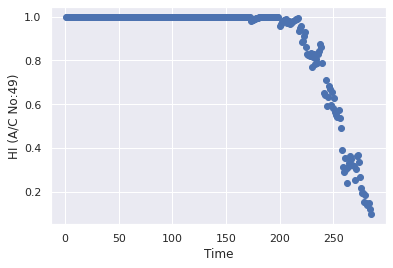

In [128]:
import seaborn as sns
from scipy.optimize import curve_fit
def func(x,a,b,c,d):
    return d+a*(np.exp(c+b*x)-np.exp(c))
%matplotlib inline 
sns.set()
d = df[df['id'] == 49]

y = d['HI']
y = np.asarray(y)
# y = ewma(y,alpha = 0.2)
x = d['cycle']
ax = plt.scatter(x ,y)
plt.ylabel('HI (A/C No:49)')
plt.xlabel('Time')
max_time = d.shape[0]
# popt, pcov = curve_fit(func,x,y)
# plt.plot(x,func(x,*popt))

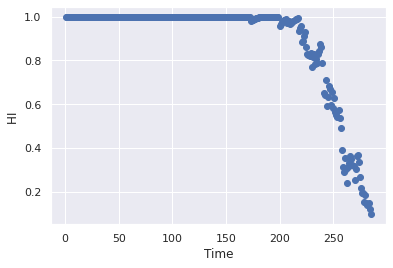

In [62]:
from scipy.optimize import curve_fit
def func(x,a,b,c,d,e):
    return d+a*(np.exp(c+b*(x))-np.exp(c))\

d = df[df['id'] == 49]
x = np.array(d['cycle'])
y = np.array(d['HI'])
y = ewma(y,alpha = 0.2)
popt, pcov = curve_fit(func,x,y)
plt.plot(x,func(x,*popt))
plt.ylabel('HI ')
plt.xlabel('Time')
plt.scatter(x,y)
# print(popt)
# print(pcov)



In [92]:
#finding the fitting exponential pattern for each unit in training dataset
from scipy.optimize import curve_fit

#equation used to fit the curves
def func(x,a,b,c,d):
    return d+a*(np.exp(b*x+c)-np.exp(c))

fitted_curve_parameters = []    
covariance = []
var = 0

for i in range(1,n+1):

    data = df[df['id'] == i]
    x = np.array(data['cycle'])
    y = np.array(data['HI'])

    #applying EWMA filter
    y = ewma(y,alpha = 0.2)
    popt, pcov = curve_fit(func,x,y)

    parameter_var = 0
    for j in range(4):
        parameter_var = parameter_var + pcov[j][j]

    #estimating the prediction variance 
    prediction_var = 0

    if(parameter_var != float('inf')):

      estimate = []
      a = popt[0]
      b = popt[1]
      c = popt[2]
      d = popt[3]
      for element in x:
        est = func(element,a,b,c,d)
        estimate.append(est)
      prediction_var = np.var(estimate)

    else:
      prediction_var = float('inf')
            
    fitted_curve_parameters.append(popt)        
    covariance.append(prediction_var)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [0]:
# covariance

In [0]:
#importing the test dataset
test = pd.read_csv('/content/drive/My Drive/test-9-new.csv')

In [0]:
#dropping the unwanted columns
cols = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21','setting1','setting2','setting3']
test = test.drop(cols,axis = 1)

In [129]:
df_test = test

,id,cycle,HI
0,1,1,1.0
1,1,2,1.0
2,1,3,1.0
3,1,4,1.0
4,1,5,1.0
...,...,...,...
29815,218,86,1.0
29816,218,87,1.0
29817,218,88,0.8
29818,218,89,1.0


In [0]:
#saving the test data
new_HI=[]
for i in range (218):
  dd = df[df['id'] == i+1]
  y = dd['HI']
  y = np.asarray(y)
  y = ewma(y,alpha = 0.2)
  for j in range (len(y)):
    new_HI.append(y[j])
dfff = df
dfff = dfff.drop('HI',axis=1)
dfff['HI']=new_HI
dfff.to_csv('/content/drive/My Drive/RUL_pool.csv')


Text(0.5, 0, 'Time')

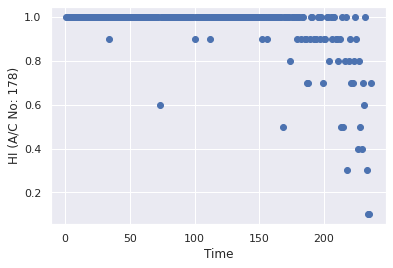

In [132]:
def get(x,a,b,c,d):
    return d+a*(np.exp(b*x+c)-np.exp(c))

import seaborn as sns
sns.set()

d = df_test[df_test['id'] == 178]
y = d['HI']
y = np.asarray(y)

# y = ewma(y,alpha = 0.2)
x = d['cycle']
ax = plt.scatter(x ,y)
plt.ylabel('HI (A/C No: 178)')
plt.xlabel('Time')

# d = df[df['id'] == 1]
# x = np.array(d['cycle'])
# # print(x)
# y = np.array(d['HI'])
# y = ewma(y,alpha = 0.2)
# popt, pcov = curve_fit(func,x,y)
# plt.plot(x,func(x,*popt))

In [107]:
num = df_test['id'].max()
num = 7

def get(x,a,b,c,d):
    return d+a*(np.exp(b*x+c)-np.exp(c))

# def get1(x,a,b,c):
#     return a*(np.exp(b*x+c)-np.exp(c))

index = 0
RUL_final = []
for t in range(num):
    data1 = df_test[df_test['id'] == (t+1)]
    r = data1.shape[0]

    # if(t<6):
    #   index = index+r
    #   continue

    HI = data1['HI']
    
    #applying the EWMA filter if needed

    # HI = np.asarray(HI)
    # HI = ewma(HI,alpha = 0.2)

    RUL_list = []
    Dis_list = []
    aircraft_num = []
    for j in range (218):
        RUL = -1
        Dis = -1
        ac_num = -1
        n = df[df['id'] == (j+1)].shape[0]
        k = n-r+1
        if(k > 0):
            if (covariance[j] != float('inf')):
                for tou in range(k):

                    #only for Tou =0 and M1 that is model obtained from unit1

                    s = 0
                    a = fitted_curve_parameters[j][0]
                    b = fitted_curve_parameters[j][1]
                    c = fitted_curve_parameters[j][2]
                    d = fitted_curve_parameters[j][3]
                    for i in range (r):
                        y = HI[i+index]
                        # y = HI[i]
                        p = get(i-r-tou,a,b,c,d)
                        # p = get1(i-r-tou,a,b,c)
                        s = s+(y-p)*(y-p)
                    dis = s/covariance[j]
                    rul = tou
                    
                    if(Dis == -1):
                        Dis = dis
                        RUL = rul
                        ac_num = j+1
                    else:
                        if(Dis > dis):
                            Dis = dis
                            RUL = rul
                            ac_num = j+1

                    #store the RUL and dis for the min dis-Tou in list dist
                    # how to get the RUL from the stored model for a given tou?
                #store the dist for each model

        if(Dis != -1):
            RUL_list.append(RUL)
            Dis_list.append(Dis)
            aircraft_num.append(ac_num)
    p = []
    p.append(aircraft_num)
    p.append(RUL_list)
    p.append(Dis_list)
    
    # create a data frame sort it by distance, reindex it and select the top 
    # 25% of data for RUL estimation

    df1 = pd.DataFrame(p,index = ['A/C No.','RUL','Dis']).T
    # pool1 = df1

    #sorting according to distance
    df1 = df1.sort_values(['Dis'])
    # pool2 = df1

    x = len(p[0])
    if(x == 0):
      RUL_final.append(0)
      index = index+r
      continue

    idx = []
    for i in range(x):
        idx.append(i)
    #re-indexing
    df1.index = idx

    #outlier removal

    df1 = df1[df1['RUL']<200]
    min_total_life = 125
    df0 = df1[df1['RUL'] > min_total_life-r]
    while(df0.shape[0] == 0):
      min_total_life = min_total_life-5
      df0 = df1[df1['RUL'] > min_total_life-r]

    df1 = df0
    len_df1 = df1.shape[0]

    #re-indexing
    re_index = []
    for i in range(len_df1):
        re_index.append(i)
    df1.index = re_index
    # pool3 = df1

    ## performing candidate selection

    len_df1 = (int)(len_df1)/6
    d0 = df1['Dis'][0]

    df2 = df1[df1['Dis']< 1.25*d0]
    len_df2 = df2.shape[0]

    if(len_df2 < 10):
      # p = min(len_df1,10)
      df2 = df1[df1.index < len_df1]

    # pool4 = df2

    Q1 = df2['RUL'].quantile(0.25)
    Q2 = df2['RUL'].quantile(0.50)
    Q3 = df2['RUL'].quantile(0.75)
    I1 = Q3 - Q2
    I2 = Q2 - Q1

    # Filtering Values between Q1-1.5IQR and Q3+1.5IQR

    RUL_min = df2['RUL'].min()
    RUL_max = df2['RUL'].max()
    RUL_est = (13*RUL_min + 10*RUL_max)/23

    df2 = df2[df2['RUL']<(Q2+2*I1)]
    if(df2.shape[0]>0):
      RUL_min = df2['RUL'].min()
      RUL_max = df2['RUL'].max()
      RUL_est = (13*RUL_min + 10*RUL_max)/23
      
    df2 = df2[df2['RUL']> (Q2-3*I2)]   
    if(df2.shape[0]>0):
      RUL_min = df2['RUL'].min()
      RUL_max = df2['RUL'].max()
      RUL_est = (13*RUL_min + 10*RUL_max)/23
      
    re_re_index = []
    len_df2 = df2.shape[0]
    for i in range(len_df2):
        re_re_index.append(i)
    df2.index = re_re_index
    # pool5 = df2

    # print(t+1," ",RUL_est)
    RUL_final.append(RUL_est)
    index = index+r

7   55.56521739130435


In [0]:
# pool1

In [0]:

pool5.to_csv('/content/drive/My Drive/RUL_pool.csv')

In [0]:
with open('/content/drive/My Drive/RUL_test_data-3.txt', 'w') as f:
  for item in RUL_final:
    f.write("%s\n" % item)

In [0]:
file1 = open('/content/drive/My Drive/RUL_test_data-3.txt', 'r')
RUL_final1 = np.loadtxt(file1, delimiter=',')
file1.close()

file2 = open('/content/drive/My Drive/submit_test_9_1131.txt', 'r')
RUL_final2 = np.loadtxt(file2, delimiter=',')
file2.close()

In [0]:
n1 = len(RUL_final1)
# RUL_final

In [0]:
RUL_final = RUL_final1
for i in range (n1):
  a = min(RUL_final1[i],RUL_final2[i])
  b = max(RUL_final1[i],RUL_final2[i])
  RUL_final[i] = (13*a+10*b)/23


In [0]:
# RUL_final
with open('/content/drive/My Drive/submit_test14.txt', 'w') as f:
  for item in RUL_final:
    f.write("%s\n" % item)